# I. Giới thiệu (Introduction)
Bộ dữ liệu CIFAR-100 là một thách thức lớn trong bài toán thị giác máy tính do độ phân giải thấp (32x32 pixels) và số lượng lớp phân loại lớn (100 lớp). Notebook này thực hiện một nghiên cứu so sánh toàn diện về hiệu năng của các kiến trúc mạng nơ-ron khác nhau trên tập dữ liệu này.

#### Mục tiêu của nghiên cứu là so sánh hai chiến lược huấn luyện chính:

1. Training from Scratch (Huấn luyện từ đầu): Xây dựng và huấn luyện mô hình với trọng số ngẫu nhiên trên ảnh gốc 32x32.

2. Fine-tuning (Tinh chỉnh - Transfer Learning): Sử dụng các mô hình đã được huấn luyện trước (Pre-trained) trên ImageNet hoặc LAION-2B, sau đó tinh chỉnh trên ảnh được resize lên 224x224.

#### Các mô hình được đánh giá bao gồm:

* Simple CNN: Mô hình cơ sở (Baseline) tự xây dựng.

* VGG-19 & ResNet-50: Đại diện tiêu biểu cho kiến trúc Convolutional Neural Networks (CNN) sâu.

* CoCa (Contrastive Captioners): Đại diện cho kiến trúc hiện đại dựa trên Transformer và cơ chế Multi-modal (Vision-Text), sử dụng OpenCLIP.

# II. Cài đặt và Khai báo thư viện

In [4]:
pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch.nn as nn
import torch.optim as optim
import timm 
from tqdm import tqdm 
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [25]:
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False  

# III. Cấu hình chung tham số

In [6]:
Batch_size = 64
Num_workers = 2
Val_ratio=0.2
Seed =42

# IV. Xử lí dữ liệu

#### Đây là bước quan trọng nhất ảnh hưởng đến hiệu năng của Transfer Learning. Mỗi kiến trúc mô hình yêu cầu một định dạng đầu vào cụ thể:

* Nhóm Scratch (SimpleCNN, ResNet, VGG - 32x32): Sử dụng chuẩn hóa (Normalize) theo thống kê của CIFAR-100.

* Nhóm Pre-trained CNN (ResNet50, VGG19 - 224x224): Sử dụng chuẩn hóa theo thống kê của ImageNet để phù hợp với trọng số đã học.

* Nhóm CoCa (OpenCLIP): Sử dụng hàm Transform đặc thù của CLIP/CoCa (bao gồm resize và chuẩn hóa riêng biệt) để bảo toàn không gian đặc trưng (feature space) mà mô hình đã học từ dữ liệu lớn LAION-2B.

Hàm get_data_loaders dưới đây được thiết kế linh hoạt để tự động chọn Transform phù hợp dựa trên tên mô hình.

In [7]:
import open_clip
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

CIFAR100_STATS = ((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
IMAGENET_STATS = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

def get_data_loaders(model_name, image_size, batch_size, seed=42):

    if "coca" in model_name.lower():
        print(f"--> Đang tạo Transform riêng chuẩn cho {model_name} (OpenCLIP)...")
        _, _, preprocess_val = open_clip.create_model_and_transforms(
            'coca_ViT-B-32', pretrained='laion2b_s13b_b90k'
        )
        clip_normalize = preprocess_val.transforms[-1] 
        
        train_tf = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Augmentation
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            clip_normalize # Dùng Normalize chuẩn của CLIP
        ])
        val_test_tf = preprocess_val 
        
    elif "finetune" in model_name.lower() and image_size == 224:
        print(f"--> Đang tạo Transform chuẩn ImageNet cho {model_name}...")
        train_tf = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(*IMAGENET_STATS)
        ])
        val_test_tf = transforms.Compose([
            transforms.Resize(224), 
            transforms.ToTensor(),
            transforms.Normalize(*IMAGENET_STATS)
        ])
        
    else:
        print(f"--> Đang tạo Transform chuẩn CIFAR-100 cho {model_name} (Scratch/32x32)...")
        train_tf = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(*CIFAR100_STATS)
        ])
        val_test_tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(*CIFAR100_STATS)
        ])
    raw_data = CIFAR100(root='./data', train=True, download=True)
    targets = raw_data.targets
    
    train_idx, val_idx = train_test_split(
        np.arange(len(targets)), 
        test_size=0.2, 
        shuffle=True, 
        stratify=targets, 
        random_state=seed
    )
    train_dataset = Subset(CIFAR100(root='./data', train=True, transform=train_tf), train_idx)
    val_dataset = Subset(CIFAR100(root='./data', train=True, transform=val_test_tf), val_idx)
    test_dataset = CIFAR100(root='./data', train=False, transform=val_test_tf)

    num_workers = 2
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                             num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, test_loader

# V. Quy Trình huấn luyện và đánh giá

In [8]:
import torch.nn as nn
import torch.optim as optim
import timm 
from tqdm import tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # 1. Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 2. B
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 3. Tính toán chỉ số
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Cập nhật thanh loading bar
        pbar.set_postfix({'loss': running_loss/len(loader)})
        
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc
    

In [9]:
def evaluate(model, loader, criterion, device):
    model.eval() # Chuyển sang chế độ Eval (tắt Dropout, khóa BatchNorm)
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): 
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc
    

# VI. Định nghĩa kiến trúc mô hình


### Simple CNN: 
Một mạng CNN đơn giản với 3 lớp tích chập, dùng để thiết lập mức sàn (baseline) cho độ chính xác.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        self.flatten_size = 128 * 4 * 4 
        
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, num_classes) 
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.pool(F.relu(self.conv3(x))) 
        
        x = x.view(-1, self.flatten_size) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)                      
        
        return x

### VGG19_Scratch:
Mạng sâu với kiến trúc chuỗi (Sequential) các khối VGG blocks. Phiên bản scratch được thiết kế phù hợp với input 32x32.

In [11]:
import torch
import torch.nn as nn

class VGG19_Scratch(nn.Module):
    def __init__(self, num_classes=100):
        super(VGG19_Scratch, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
    
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
               
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) 
        
        self.fcblock = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        
        x = self.avgpool(x) 
        x = self.fcblock(x)
        return x

### Resnet50_Scratch 
Sử dụng kiến trúc Residual Connections (kết nối tắt) giúp giải quyết vấn đề biến mất đạo hàm (vanishing gradient) khi huấn luyện mạng sâu

In [12]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.block2 =nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size= 1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion)
        )
        
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        
        # Nếu kích thước không khớp (do stride hoặc expansion), cần transform input
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        rs = self.block1(x)
        rs = self.block2(rs)
        rs = self.block3(rs)
        rs += self.shortcut(x) 
        rs = self.relu(rs)
        return rs

class ResNet50_Scratch(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet50_Scratch, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # --- CÁC KHỐI (ResNet-50 structure: 3-4-6-3) ---
        # Layer 1: Output 32x32 (64 -> 256 channels)
        self.layer1 = self._make_layer(64, 3, stride=1)
        
        # Layer 2: Output 16x16 (128 -> 512 channels)
        self.layer2 = self._make_layer(128, 4, stride=2)
        
        # Layer 3: Output 8x8 (256 -> 1024 channels)
        self.layer3 = self._make_layer(256, 6, stride=2)
        
        self.layer4 = self._make_layer(512, 3, stride=2)
        
        # --- HEAD ---
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(Bottleneck(self.in_channels, out_channels, s))
            self.in_channels = out_channels * Bottleneck.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        
        out = self.layer1(out) 
        out = self.layer2(out) 
        out = self.layer3(out)
        out = self.layer4(out) 
        
        out = self.avgpool(out) 
        out = torch.flatten(out, 1)
        out = self.fc(out)     
        return out

## VGG19 & ResNet50 (fine tuning)

In [13]:
from torchvision import models
def get_finetune_model(model_name, num_classes=100):
    model_name = model_name.lower()
    
    # 1. RESNET-50
    if model_name == 'resnet50':
        weights = models.ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model

    # 2. VGG-19 (Batch Norm)
    else:
        weights = models.VGG19_BN_Weights.DEFAULT
        model = models.vgg19_bn(weights=weights)
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_features, num_classes)
        return model

## CoCa

In [14]:
import open_clip
import torch.nn as nn

class CoCa_Finetune(nn.Module):
    def __init__(self, num_classes=100):
        super(CoCa_Finetune, self).__init__()
        print("Loading CoCa pretrained weights (Image Encoder only)...")
        model, _, _ = open_clip.create_model_and_transforms(
            'coca_ViT-B-32', 
            pretrained='laion2b_s13b_b90k'
        )
        self.visual = model.visual
        
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.visual(x)
        if isinstance(x, tuple):
            x = x[0]
        x = self.fc(x)
        return x

# VII. Quản lý thực nghiệm

Hàm run_experiment_manager là trung tâm điều khiển của notebook này. Nó tự động thực thi chuỗi các thí nghiệm với cấu hình khác nhau:

1. Chiến lược Scratch:

* Epochs: 30-50 (Cần nhiều thời gian để hội tụ).

* Learning Rate: Khởi tạo cao (0.01 - 0.05) và sử dụng MultiStepLR để giảm dần khi loss bão hòa.

* Input: 32x32.

Chiến lược Fine-tuning:

* Epochs: 7 (Hội tụ rất nhanh do đã có kiến thức nền).

* Learning Rate: Rất thấp (1e-4 đến 5e-5) để tránh phá vỡ các trọng số đã được học.

* Input: 224x224 (Resize).

* Batch_size của các model này được giảm xuống (16 hoặc 32) để tránh lỗi tràn bộ nhớ (OOM) do kích thước ảnh lớn.

In [15]:
def get_model_wrapper(model_name, num_classes=100):
    print(f"Initializing {model_name}...")
    
    if model_name == "SimpleCNN":
        return SimpleCNN(num_classes)
    elif model_name == "VGG19_Scratch":
        model = VGG19_Scratch(num_classes=num_classes) 
        return model
    elif model_name == "ResNet50_Scratch":
        model = ResNet50_Scratch(num_classes=num_classes)
        return model
    elif model_name == "VGG19_Finetune":
        model = get_finetune_model('VGG19',num_classes=num_classes)
        return model
    elif model_name == "ResNet50_Finetune":
        model = get_finetune_model('resnet50',num_classes=num_classes)
        return model
    elif model_name == "CoCa_Finetune":
        return CoCa_Finetune(num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")

## Trình quản lí thực nghiệm

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import os
import matplotlib.pyplot as plt
# Biến lưu kết quả tích lũy
global_results_list = []
global_history_dict = {}
# Hàm vẽ biểu đồ 
def plot_single_model_history(history, model_name):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-s', label='Validation Loss')
    plt.title(f'{model_name}: Loss Curve')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-o', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'g-s', label='Validation Acc')
    plt.title(f'{model_name}: Accuracy Curve')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout(); plt.show()

# --- HÀM CHẠY LẺ 1 MODEL ---
def run_single_model(exp_config):
    print(f"\n{'='*20} Running: {exp_config['name']} ({exp_config['type']}) {'='*20}")
    
    criterion = nn.CrossEntropyLoss()
    
    # 1. Prepare Data
    current_batch_size = exp_config.get('batch_size', 64)
    train_loader, val_loader, test_loader = get_data_loaders(
        model_name=exp_config['name'], 
        image_size=exp_config['img_size'], 
        batch_size=current_batch_size
    )
    
    # 2. Init Model & Optimizer
    model = get_model_wrapper(exp_config['name'])
    model = model.to(device)
    num_params = sum(p.numel() for p in model.parameters()) # Tính số tham số để vẽ biểu đồ
    
    if exp_config['type'] == 'scratch':
        optimizer = optim.SGD(model.parameters(), lr=exp_config['lr'], momentum=0.9, weight_decay=5e-4)
    else:
        optimizer = optim.Adam(model.parameters(), lr=exp_config['lr'])
        
    scheduler = None
    if exp_config.get('scheduler') and exp_config['scheduler']['use']:
        scheduler = MultiStepLR(optimizer, 
                                milestones=exp_config['scheduler']['milestones'], 
                                gamma=exp_config['scheduler']['gamma'])

    best_val_acc = 0.0
    
    # Lưu history riêng cho model này
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # 3. Training Loop
    for epoch in range(exp_config['epochs']):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{exp_config['epochs']} [LR: {current_lr:.1e}]")
        
        t_loss, t_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = evaluate(model, val_loader, criterion, device)
        
        if scheduler: scheduler.step()
        
        history['train_loss'].append(t_loss)
        history['val_loss'].append(v_loss)
        history['train_acc'].append(t_acc)
        history['val_acc'].append(v_acc)
        
        print(f"   Train Loss: {t_loss:.4f} | Acc: {t_acc:.2f}%")
        print(f"   Val Loss:   {v_loss:.4f} | Acc: {v_acc:.2f}%")
        
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            torch.save(model.state_dict(), f"{exp_config['name']}_best.pth")
    
    # 4. Vẽ biểu đồ lẻ ngay lập tức
    print(f"--> Biểu đồ training của riêng {exp_config['name']}:")
    plot_single_model_history(history, exp_config['name'])

    # 5. Final Test
    if os.path.exists(f"{exp_config['name']}_best.pth"):
        model.load_state_dict(torch.load(f"{exp_config['name']}_best.pth"))
        
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"Original Test Result: {test_acc:.2f}%")
    
    # --- QUAN TRỌNG: LƯU VÀO BIẾN TOÀN CỤC ---
    # Kiểm tra xem model đã có trong list chưa, nếu có thì xóa cũ đi để cập nhật mới
    global global_results_list, global_history_dict
    
    # Xóa kết quả cũ của model này nếu chạy lại
    global_results_list = [item for item in global_results_list if item['Model'] != exp_config['name']]
    
    # Thêm kết quả mới
    global_results_list.append({
        "Model": exp_config['name'],
        "Type": exp_config['type'],
        "Test Accuracy": test_acc,
        "Params": f"{num_params/1e6:.2f}M"
    })
    
    # Lưu history (chỉ cần lấy acc val để vẽ biểu đồ tổng hợp)
    global_history_dict[exp_config['name']] = {"val": history['val_acc']}
    # ------------------------------------------

    del model, optimizer, scheduler
    torch.cuda.empty_cache()
    
    return test_acc


### 1. Chạy SimpleCNN


==================== Running: SimpleCNN (scratch) ====================
--> Đang tạo Transform chuẩn CIFAR-100 cho SimpleCNN (Scratch/32x32)...


100%|██████████| 169M/169M [00:02<00:00, 74.8MB/s] 


Initializing SimpleCNN...
Epoch 1/120 [LR: 1.0e-03]


   Train Loss: 4.6020 | Acc: 1.18%
   Val Loss:   4.5931 | Acc: 1.84%
Epoch 2/120 [LR: 1.0e-03]


   Train Loss: 4.5654 | Acc: 2.03%
   Val Loss:   4.4808 | Acc: 3.59%
Epoch 3/120 [LR: 1.0e-03]


   Train Loss: 4.3429 | Acc: 4.23%
   Val Loss:   4.1132 | Acc: 7.00%
Epoch 4/120 [LR: 1.0e-03]


   Train Loss: 4.1381 | Acc: 6.27%
   Val Loss:   3.9789 | Acc: 8.50%
Epoch 5/120 [LR: 1.0e-03]


   Train Loss: 4.0265 | Acc: 7.88%
   Val Loss:   3.8774 | Acc: 10.07%
Epoch 6/120 [LR: 1.0e-03]


   Train Loss: 3.9368 | Acc: 9.25%
   Val Loss:   3.7751 | Acc: 12.04%
Epoch 7/120 [LR: 1.0e-03]


   Train Loss: 3.8463 | Acc: 10.69%
   Val Loss:   3.6790 | Acc: 13.47%
Epoch 8/120 [LR: 1.0e-03]


   Train Loss: 3.7648 | Acc: 12.18%
   Val Loss:   3.5896 | Acc: 15.67%
Epoch 9/120 [LR: 1.0e-03]


   Train Loss: 3.6930 | Acc: 13.26%
   Val Loss:   3.5258 | Acc: 16.60%
Epoch 10/120 [LR: 1.0e-03]


   Train Loss: 3.6236 | Acc: 14.72%
   Val Loss:   3.4462 | Acc: 18.05%
Epoch 11/120 [LR: 1.0e-03]


   Train Loss: 3.5625 | Acc: 15.84%
   Val Loss:   3.4028 | Acc: 18.26%
Epoch 12/120 [LR: 1.0e-03]


   Train Loss: 3.4956 | Acc: 16.64%
   Val Loss:   3.3418 | Acc: 19.45%
Epoch 13/120 [LR: 1.0e-03]


   Train Loss: 3.4481 | Acc: 17.75%
   Val Loss:   3.2796 | Acc: 20.89%
Epoch 14/120 [LR: 1.0e-03]


   Train Loss: 3.3965 | Acc: 18.63%
   Val Loss:   3.2302 | Acc: 21.68%
Epoch 15/120 [LR: 1.0e-03]


   Train Loss: 3.3364 | Acc: 19.47%
   Val Loss:   3.1516 | Acc: 23.26%
Epoch 16/120 [LR: 1.0e-03]


   Train Loss: 3.2828 | Acc: 20.30%
   Val Loss:   3.1248 | Acc: 23.65%
Epoch 17/120 [LR: 1.0e-03]


   Train Loss: 3.2482 | Acc: 20.91%
   Val Loss:   3.0467 | Acc: 24.71%
Epoch 18/120 [LR: 1.0e-03]


   Train Loss: 3.2043 | Acc: 21.87%
   Val Loss:   3.0149 | Acc: 26.18%
Epoch 19/120 [LR: 1.0e-03]


   Train Loss: 3.1619 | Acc: 22.57%
   Val Loss:   2.9587 | Acc: 27.01%
Epoch 20/120 [LR: 1.0e-03]


   Train Loss: 3.1247 | Acc: 23.26%
   Val Loss:   2.9226 | Acc: 27.73%
Epoch 21/120 [LR: 1.0e-03]


   Train Loss: 3.0917 | Acc: 24.11%
   Val Loss:   2.8800 | Acc: 28.52%
Epoch 22/120 [LR: 1.0e-03]


   Train Loss: 3.0518 | Acc: 24.53%
   Val Loss:   2.8609 | Acc: 28.81%
Epoch 23/120 [LR: 1.0e-03]


   Train Loss: 3.0290 | Acc: 25.25%
   Val Loss:   2.8228 | Acc: 30.03%
Epoch 24/120 [LR: 1.0e-03]


   Train Loss: 2.9891 | Acc: 26.08%
   Val Loss:   2.7694 | Acc: 30.92%
Epoch 25/120 [LR: 1.0e-03]


   Train Loss: 2.9608 | Acc: 26.52%
   Val Loss:   2.7500 | Acc: 31.42%
Epoch 26/120 [LR: 1.0e-03]


   Train Loss: 2.9336 | Acc: 27.01%
   Val Loss:   2.7226 | Acc: 32.15%
Epoch 27/120 [LR: 1.0e-03]


   Train Loss: 2.8931 | Acc: 27.57%
   Val Loss:   2.6908 | Acc: 32.52%
Epoch 28/120 [LR: 1.0e-03]


   Train Loss: 2.8762 | Acc: 28.25%
   Val Loss:   2.6588 | Acc: 33.43%
Epoch 29/120 [LR: 1.0e-03]


   Train Loss: 2.8521 | Acc: 28.45%
   Val Loss:   2.6469 | Acc: 33.87%
Epoch 30/120 [LR: 1.0e-03]


   Train Loss: 2.8132 | Acc: 29.58%
   Val Loss:   2.6355 | Acc: 33.73%
Epoch 31/120 [LR: 1.0e-03]


   Train Loss: 2.7862 | Acc: 29.86%
   Val Loss:   2.6002 | Acc: 34.34%
Epoch 32/120 [LR: 1.0e-03]


   Train Loss: 2.7609 | Acc: 30.54%
   Val Loss:   2.5492 | Acc: 35.64%
Epoch 33/120 [LR: 1.0e-03]


   Train Loss: 2.7407 | Acc: 30.71%
   Val Loss:   2.5435 | Acc: 35.96%
Epoch 34/120 [LR: 1.0e-03]


   Train Loss: 2.7115 | Acc: 31.27%
   Val Loss:   2.5074 | Acc: 36.37%
Epoch 35/120 [LR: 1.0e-03]


   Train Loss: 2.6791 | Acc: 31.93%
   Val Loss:   2.4835 | Acc: 37.38%
Epoch 36/120 [LR: 1.0e-03]


   Train Loss: 2.6684 | Acc: 32.12%
   Val Loss:   2.4656 | Acc: 37.36%
Epoch 37/120 [LR: 1.0e-03]


   Train Loss: 2.6340 | Acc: 32.79%
   Val Loss:   2.4411 | Acc: 37.67%
Epoch 38/120 [LR: 1.0e-03]


   Train Loss: 2.6105 | Acc: 33.35%
   Val Loss:   2.4321 | Acc: 38.37%
Epoch 39/120 [LR: 1.0e-03]


   Train Loss: 2.5829 | Acc: 33.99%
   Val Loss:   2.4052 | Acc: 38.50%
Epoch 40/120 [LR: 1.0e-03]


   Train Loss: 2.5673 | Acc: 33.79%
   Val Loss:   2.3871 | Acc: 39.03%
Epoch 41/120 [LR: 1.0e-03]


   Train Loss: 2.5415 | Acc: 34.64%
   Val Loss:   2.3641 | Acc: 39.42%
Epoch 42/120 [LR: 1.0e-03]


   Train Loss: 2.5222 | Acc: 35.10%
   Val Loss:   2.3408 | Acc: 39.97%
Epoch 43/120 [LR: 1.0e-03]


   Train Loss: 2.4966 | Acc: 35.55%
   Val Loss:   2.3154 | Acc: 40.36%
Epoch 44/120 [LR: 1.0e-03]


   Train Loss: 2.4794 | Acc: 36.13%
   Val Loss:   2.3228 | Acc: 40.68%
Epoch 45/120 [LR: 1.0e-03]


   Train Loss: 2.4599 | Acc: 36.56%
   Val Loss:   2.3093 | Acc: 40.46%
Epoch 46/120 [LR: 1.0e-03]


   Train Loss: 2.4329 | Acc: 36.79%
   Val Loss:   2.2751 | Acc: 40.85%
Epoch 47/120 [LR: 1.0e-03]


   Train Loss: 2.4118 | Acc: 37.02%
   Val Loss:   2.2696 | Acc: 41.66%
Epoch 48/120 [LR: 1.0e-03]


   Train Loss: 2.3954 | Acc: 37.74%
   Val Loss:   2.2208 | Acc: 42.78%
Epoch 49/120 [LR: 1.0e-03]


   Train Loss: 2.3761 | Acc: 38.07%
   Val Loss:   2.2484 | Acc: 42.15%
Epoch 50/120 [LR: 1.0e-03]


   Train Loss: 2.3590 | Acc: 38.41%
   Val Loss:   2.2061 | Acc: 42.82%
Epoch 51/120 [LR: 1.0e-03]


   Train Loss: 2.3504 | Acc: 38.36%
   Val Loss:   2.2068 | Acc: 43.07%
Epoch 52/120 [LR: 1.0e-03]


   Train Loss: 2.3234 | Acc: 39.21%
   Val Loss:   2.1717 | Acc: 43.43%
Epoch 53/120 [LR: 1.0e-03]


   Train Loss: 2.2968 | Acc: 39.66%
   Val Loss:   2.1611 | Acc: 43.99%
Epoch 54/120 [LR: 1.0e-03]


   Train Loss: 2.2911 | Acc: 39.95%
   Val Loss:   2.1657 | Acc: 43.50%
Epoch 55/120 [LR: 1.0e-03]


   Train Loss: 2.2710 | Acc: 40.25%
   Val Loss:   2.1431 | Acc: 44.40%
Epoch 56/120 [LR: 1.0e-03]


   Train Loss: 2.2570 | Acc: 40.77%
   Val Loss:   2.1358 | Acc: 44.50%
Epoch 57/120 [LR: 1.0e-03]


   Train Loss: 2.2368 | Acc: 41.03%
   Val Loss:   2.1146 | Acc: 44.96%
Epoch 58/120 [LR: 1.0e-03]


   Train Loss: 2.2218 | Acc: 41.20%
   Val Loss:   2.1302 | Acc: 44.70%
Epoch 59/120 [LR: 1.0e-03]


   Train Loss: 2.2056 | Acc: 41.63%
   Val Loss:   2.0898 | Acc: 45.49%
Epoch 60/120 [LR: 1.0e-03]


   Train Loss: 2.1886 | Acc: 42.04%
   Val Loss:   2.1119 | Acc: 44.71%
Epoch 61/120 [LR: 1.0e-03]


   Train Loss: 2.1737 | Acc: 42.23%
   Val Loss:   2.0801 | Acc: 45.77%
Epoch 62/120 [LR: 1.0e-03]


   Train Loss: 2.1670 | Acc: 42.53%
   Val Loss:   2.0742 | Acc: 45.81%
Epoch 63/120 [LR: 1.0e-03]


   Train Loss: 2.1476 | Acc: 42.92%
   Val Loss:   2.0557 | Acc: 46.18%
Epoch 64/120 [LR: 1.0e-03]


   Train Loss: 2.1273 | Acc: 43.34%
   Val Loss:   2.0476 | Acc: 46.24%
Epoch 65/120 [LR: 1.0e-03]


   Train Loss: 2.1199 | Acc: 43.64%
   Val Loss:   2.0589 | Acc: 46.17%
Epoch 66/120 [LR: 1.0e-03]


   Train Loss: 2.1078 | Acc: 43.94%
   Val Loss:   2.0337 | Acc: 46.53%
Epoch 67/120 [LR: 1.0e-03]


   Train Loss: 2.0895 | Acc: 44.14%
   Val Loss:   2.0169 | Acc: 47.08%
Epoch 68/120 [LR: 1.0e-03]


   Train Loss: 2.0844 | Acc: 44.38%
   Val Loss:   2.0327 | Acc: 46.58%
Epoch 69/120 [LR: 1.0e-03]


   Train Loss: 2.0770 | Acc: 44.37%
   Val Loss:   1.9922 | Acc: 47.71%
Epoch 70/120 [LR: 1.0e-03]


   Train Loss: 2.0583 | Acc: 44.83%
   Val Loss:   2.0145 | Acc: 47.45%
Epoch 71/120 [LR: 1.0e-03]


   Train Loss: 2.0429 | Acc: 45.20%
   Val Loss:   2.0035 | Acc: 47.17%
Epoch 72/120 [LR: 1.0e-03]


   Train Loss: 2.0211 | Acc: 45.77%
   Val Loss:   1.9808 | Acc: 47.84%
Epoch 73/120 [LR: 1.0e-03]


   Train Loss: 2.0201 | Acc: 45.62%
   Val Loss:   1.9849 | Acc: 47.77%
Epoch 74/120 [LR: 1.0e-03]


   Train Loss: 2.0061 | Acc: 45.89%
   Val Loss:   1.9699 | Acc: 47.84%
Epoch 75/120 [LR: 1.0e-03]


   Train Loss: 1.9927 | Acc: 46.14%
   Val Loss:   1.9652 | Acc: 48.48%
Epoch 76/120 [LR: 1.0e-03]


   Train Loss: 1.9702 | Acc: 46.82%
   Val Loss:   1.9680 | Acc: 48.30%
Epoch 77/120 [LR: 1.0e-03]


   Train Loss: 1.9783 | Acc: 46.29%
   Val Loss:   1.9567 | Acc: 48.29%
Epoch 78/120 [LR: 1.0e-03]


   Train Loss: 1.9616 | Acc: 47.18%
   Val Loss:   1.9613 | Acc: 48.52%
Epoch 79/120 [LR: 1.0e-03]


   Train Loss: 1.9522 | Acc: 46.89%
   Val Loss:   1.9495 | Acc: 48.71%
Epoch 80/120 [LR: 1.0e-03]


   Train Loss: 1.9429 | Acc: 47.35%
   Val Loss:   1.9416 | Acc: 48.87%
Epoch 81/120 [LR: 1.0e-03]


   Train Loss: 1.9300 | Acc: 47.71%
   Val Loss:   1.9416 | Acc: 48.83%
Epoch 82/120 [LR: 1.0e-03]


   Train Loss: 1.9162 | Acc: 48.02%
   Val Loss:   1.9165 | Acc: 49.59%
Epoch 83/120 [LR: 1.0e-03]


   Train Loss: 1.9153 | Acc: 47.88%
   Val Loss:   1.9512 | Acc: 48.32%
Epoch 84/120 [LR: 1.0e-03]


   Train Loss: 1.9009 | Acc: 48.50%
   Val Loss:   1.9219 | Acc: 49.72%
Epoch 85/120 [LR: 1.0e-03]


   Train Loss: 1.8908 | Acc: 48.48%
   Val Loss:   1.9199 | Acc: 49.59%
Epoch 86/120 [LR: 1.0e-03]


   Train Loss: 1.8767 | Acc: 48.86%
   Val Loss:   1.9053 | Acc: 49.40%
Epoch 87/120 [LR: 1.0e-03]


   Train Loss: 1.8633 | Acc: 49.09%
   Val Loss:   1.9093 | Acc: 49.91%
Epoch 88/120 [LR: 1.0e-03]


   Train Loss: 1.8582 | Acc: 49.35%
   Val Loss:   1.9033 | Acc: 49.79%
Epoch 89/120 [LR: 1.0e-03]


   Train Loss: 1.8489 | Acc: 49.38%
   Val Loss:   1.8861 | Acc: 50.19%
Epoch 90/120 [LR: 1.0e-03]


   Train Loss: 1.8355 | Acc: 49.67%
   Val Loss:   1.8851 | Acc: 50.12%
Epoch 91/120 [LR: 1.0e-03]


   Train Loss: 1.8321 | Acc: 49.91%
   Val Loss:   1.8814 | Acc: 50.05%
Epoch 92/120 [LR: 1.0e-03]


   Train Loss: 1.8213 | Acc: 49.76%
   Val Loss:   1.8959 | Acc: 49.63%
Epoch 93/120 [LR: 1.0e-03]


   Train Loss: 1.8106 | Acc: 50.36%
   Val Loss:   1.9065 | Acc: 49.61%
Epoch 94/120 [LR: 1.0e-03]


   Train Loss: 1.8093 | Acc: 50.34%
   Val Loss:   1.8900 | Acc: 50.22%
Epoch 95/120 [LR: 1.0e-03]


   Train Loss: 1.7960 | Acc: 50.58%
   Val Loss:   1.8810 | Acc: 50.39%
Epoch 96/120 [LR: 1.0e-03]


   Train Loss: 1.7880 | Acc: 50.76%
   Val Loss:   1.8831 | Acc: 50.57%
Epoch 97/120 [LR: 1.0e-03]


   Train Loss: 1.7816 | Acc: 51.12%
   Val Loss:   1.8742 | Acc: 50.14%
Epoch 98/120 [LR: 1.0e-03]


   Train Loss: 1.7782 | Acc: 51.02%
   Val Loss:   1.8735 | Acc: 50.56%
Epoch 99/120 [LR: 1.0e-03]


   Train Loss: 1.7666 | Acc: 51.09%
   Val Loss:   1.8532 | Acc: 50.94%
Epoch 100/120 [LR: 1.0e-03]


   Train Loss: 1.7527 | Acc: 51.87%
   Val Loss:   1.8575 | Acc: 50.68%
Epoch 101/120 [LR: 1.0e-03]


   Train Loss: 1.7458 | Acc: 51.88%
   Val Loss:   1.8541 | Acc: 50.78%
Epoch 102/120 [LR: 1.0e-03]


   Train Loss: 1.7357 | Acc: 52.05%
   Val Loss:   1.8446 | Acc: 50.91%
Epoch 103/120 [LR: 1.0e-03]


   Train Loss: 1.7219 | Acc: 52.06%
   Val Loss:   1.8464 | Acc: 51.06%
Epoch 104/120 [LR: 1.0e-03]


   Train Loss: 1.7284 | Acc: 52.34%
   Val Loss:   1.8366 | Acc: 51.21%
Epoch 105/120 [LR: 1.0e-03]


   Train Loss: 1.7109 | Acc: 52.41%
   Val Loss:   1.8495 | Acc: 50.91%
Epoch 106/120 [LR: 1.0e-03]


   Train Loss: 1.7132 | Acc: 52.54%
   Val Loss:   1.8414 | Acc: 51.27%
Epoch 107/120 [LR: 1.0e-03]


   Train Loss: 1.7071 | Acc: 52.48%
   Val Loss:   1.8442 | Acc: 51.43%
Epoch 108/120 [LR: 1.0e-03]


   Train Loss: 1.6952 | Acc: 52.83%
   Val Loss:   1.8379 | Acc: 51.57%
Epoch 109/120 [LR: 1.0e-03]


   Train Loss: 1.6762 | Acc: 53.42%
   Val Loss:   1.8385 | Acc: 51.61%
Epoch 110/120 [LR: 1.0e-03]


   Train Loss: 1.6674 | Acc: 53.33%
   Val Loss:   1.8326 | Acc: 51.64%
Epoch 111/120 [LR: 1.0e-03]


   Train Loss: 1.6591 | Acc: 53.66%
   Val Loss:   1.8399 | Acc: 51.24%
Epoch 112/120 [LR: 1.0e-03]


   Train Loss: 1.6611 | Acc: 53.62%
   Val Loss:   1.8334 | Acc: 51.34%
Epoch 113/120 [LR: 1.0e-03]


   Train Loss: 1.6543 | Acc: 54.02%
   Val Loss:   1.8246 | Acc: 51.41%
Epoch 114/120 [LR: 1.0e-03]


   Train Loss: 1.6495 | Acc: 53.87%
   Val Loss:   1.8234 | Acc: 51.34%
Epoch 115/120 [LR: 1.0e-03]


   Train Loss: 1.6277 | Acc: 54.50%
   Val Loss:   1.8486 | Acc: 51.56%
Epoch 116/120 [LR: 1.0e-03]


   Train Loss: 1.6310 | Acc: 54.54%
   Val Loss:   1.8254 | Acc: 52.08%
Epoch 117/120 [LR: 1.0e-03]


   Train Loss: 1.6329 | Acc: 54.21%
   Val Loss:   1.8167 | Acc: 52.23%
Epoch 118/120 [LR: 1.0e-03]


   Train Loss: 1.6208 | Acc: 54.53%
   Val Loss:   1.8244 | Acc: 52.10%
Epoch 119/120 [LR: 1.0e-03]


   Train Loss: 1.6152 | Acc: 54.66%
   Val Loss:   1.8246 | Acc: 51.96%
Epoch 120/120 [LR: 1.0e-03]


   Train Loss: 1.5979 | Acc: 55.10%
   Val Loss:   1.8210 | Acc: 51.87%
--> Biểu đồ training của riêng SimpleCNN:


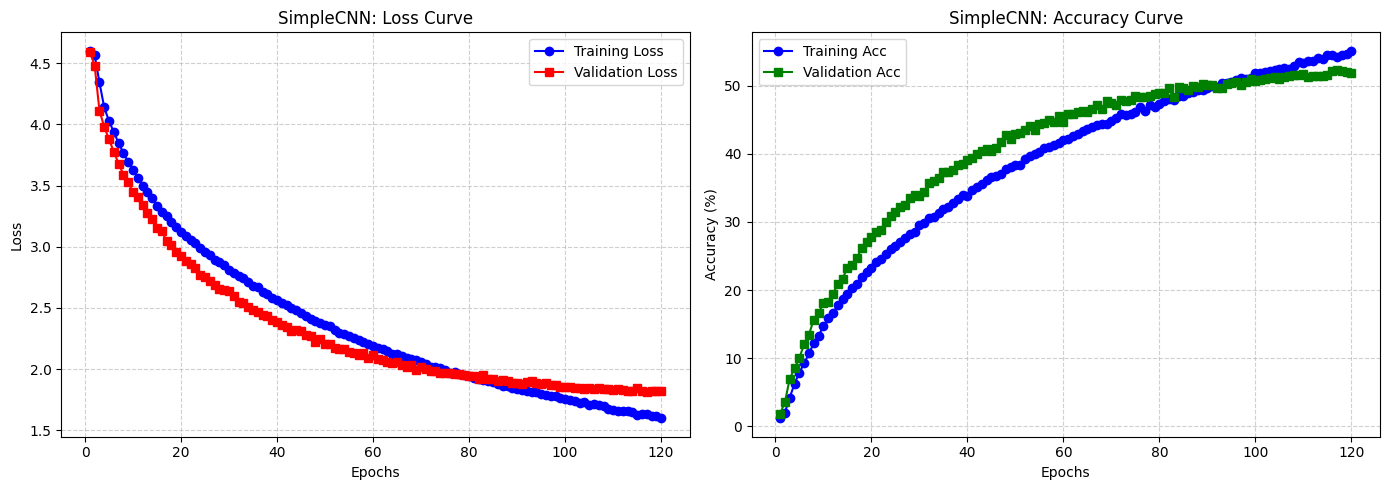

Original Test Result: 52.94%


52.94

In [17]:
run_single_model({
    "name": "SimpleCNN",
    "type": "scratch",
    "img_size": 32,
    "batch_size": 64,
    "epochs": 120,    
    "lr": 1e-3,
    "scheduler": {  
        "use": False,
    }
})

#### 2. Chạy VGG19_Scratch


==================== Running: VGG19_Scratch (scratch) ====================
--> Đang tạo Transform chuẩn CIFAR-100 cho VGG19_Scratch (Scratch/32x32)...
Initializing VGG19_Scratch...
Epoch 1/50 [LR: 1.0e-02]


   Train Loss: 4.3388 | Acc: 2.73%
   Val Loss:   4.1638 | Acc: 3.99%
Epoch 2/50 [LR: 1.0e-02]


   Train Loss: 4.0297 | Acc: 5.33%
   Val Loss:   3.8722 | Acc: 7.23%
Epoch 3/50 [LR: 1.0e-02]


   Train Loss: 3.7563 | Acc: 8.87%
   Val Loss:   3.5732 | Acc: 11.41%
Epoch 4/50 [LR: 1.0e-02]


   Train Loss: 3.5068 | Acc: 12.85%
   Val Loss:   3.3631 | Acc: 15.20%
Epoch 5/50 [LR: 1.0e-02]


   Train Loss: 3.2974 | Acc: 16.11%
   Val Loss:   3.0916 | Acc: 20.86%
Epoch 6/50 [LR: 1.0e-02]


   Train Loss: 3.1267 | Acc: 19.41%
   Val Loss:   2.9868 | Acc: 22.59%
Epoch 7/50 [LR: 1.0e-02]


   Train Loss: 2.9611 | Acc: 22.91%
   Val Loss:   2.8294 | Acc: 25.41%
Epoch 8/50 [LR: 1.0e-02]


   Train Loss: 2.8178 | Acc: 25.24%
   Val Loss:   2.9282 | Acc: 24.68%
Epoch 9/50 [LR: 1.0e-02]


   Train Loss: 2.6808 | Acc: 28.00%
   Val Loss:   2.6224 | Acc: 30.90%
Epoch 10/50 [LR: 1.0e-02]


   Train Loss: 2.5614 | Acc: 30.53%
   Val Loss:   2.4792 | Acc: 33.58%
Epoch 11/50 [LR: 1.0e-02]


   Train Loss: 2.4701 | Acc: 32.43%
   Val Loss:   2.3948 | Acc: 34.76%
Epoch 12/50 [LR: 1.0e-02]


   Train Loss: 2.3728 | Acc: 35.15%
   Val Loss:   2.5362 | Acc: 35.07%
Epoch 13/50 [LR: 1.0e-02]


   Train Loss: 2.2939 | Acc: 37.26%
   Val Loss:   2.2724 | Acc: 39.19%
Epoch 14/50 [LR: 1.0e-02]


   Train Loss: 2.2126 | Acc: 38.95%
   Val Loss:   2.1581 | Acc: 41.59%
Epoch 15/50 [LR: 1.0e-02]


   Train Loss: 2.1334 | Acc: 40.92%
   Val Loss:   2.2695 | Acc: 39.72%
Epoch 16/50 [LR: 1.0e-02]


   Train Loss: 2.0567 | Acc: 43.44%
   Val Loss:   2.1699 | Acc: 42.41%
Epoch 17/50 [LR: 1.0e-02]


   Train Loss: 1.9958 | Acc: 44.79%
   Val Loss:   2.3455 | Acc: 40.75%
Epoch 18/50 [LR: 1.0e-02]


   Train Loss: 1.9304 | Acc: 46.59%
   Val Loss:   2.0244 | Acc: 45.86%
Epoch 19/50 [LR: 1.0e-02]


   Train Loss: 1.8655 | Acc: 48.22%
   Val Loss:   1.9528 | Acc: 47.62%
Epoch 20/50 [LR: 1.0e-02]


   Train Loss: 1.8067 | Acc: 49.83%
   Val Loss:   1.9479 | Acc: 47.18%
Epoch 21/50 [LR: 1.0e-02]


   Train Loss: 1.7575 | Acc: 51.22%
   Val Loss:   2.1089 | Acc: 46.26%
Epoch 22/50 [LR: 1.0e-02]


   Train Loss: 1.7108 | Acc: 52.40%
   Val Loss:   1.9201 | Acc: 48.80%
Epoch 23/50 [LR: 1.0e-02]


   Train Loss: 1.6596 | Acc: 53.71%
   Val Loss:   1.8808 | Acc: 49.96%
Epoch 24/50 [LR: 1.0e-02]


   Train Loss: 1.6156 | Acc: 54.93%
   Val Loss:   1.8365 | Acc: 51.51%
Epoch 25/50 [LR: 1.0e-02]


   Train Loss: 1.5807 | Acc: 56.05%
   Val Loss:   1.8163 | Acc: 51.73%
Epoch 26/50 [LR: 1.0e-02]


   Train Loss: 1.5334 | Acc: 57.20%
   Val Loss:   1.8347 | Acc: 52.12%
Epoch 27/50 [LR: 1.0e-02]


   Train Loss: 1.4904 | Acc: 58.48%
   Val Loss:   1.8264 | Acc: 52.35%
Epoch 28/50 [LR: 1.0e-02]


   Train Loss: 1.4623 | Acc: 59.33%
   Val Loss:   1.8385 | Acc: 52.31%
Epoch 29/50 [LR: 1.0e-02]


   Train Loss: 1.4175 | Acc: 60.48%
   Val Loss:   1.8085 | Acc: 53.29%
Epoch 30/50 [LR: 1.0e-02]


   Train Loss: 1.4034 | Acc: 60.71%
   Val Loss:   1.8328 | Acc: 52.67%
Epoch 31/50 [LR: 1.0e-03]


   Train Loss: 1.0522 | Acc: 69.82%
   Val Loss:   1.4549 | Acc: 61.48%
Epoch 32/50 [LR: 1.0e-03]


   Train Loss: 0.9301 | Acc: 72.88%
   Val Loss:   1.4454 | Acc: 62.18%
Epoch 33/50 [LR: 1.0e-03]


   Train Loss: 0.8798 | Acc: 74.24%
   Val Loss:   1.4478 | Acc: 62.52%
Epoch 34/50 [LR: 1.0e-03]


   Train Loss: 0.8537 | Acc: 74.84%
   Val Loss:   1.4480 | Acc: 62.95%
Epoch 35/50 [LR: 1.0e-03]


   Train Loss: 0.8195 | Acc: 75.76%
   Val Loss:   1.4534 | Acc: 63.40%
Epoch 36/50 [LR: 1.0e-03]


   Train Loss: 0.7895 | Acc: 76.59%
   Val Loss:   1.4659 | Acc: 63.01%
Epoch 37/50 [LR: 1.0e-03]


   Train Loss: 0.7649 | Acc: 77.24%
   Val Loss:   1.4620 | Acc: 63.12%
Epoch 38/50 [LR: 1.0e-03]


   Train Loss: 0.7507 | Acc: 77.62%
   Val Loss:   1.4701 | Acc: 63.30%
Epoch 39/50 [LR: 1.0e-03]


   Train Loss: 0.7157 | Acc: 78.33%
   Val Loss:   1.4869 | Acc: 63.78%
Epoch 40/50 [LR: 1.0e-03]


   Train Loss: 0.6936 | Acc: 79.31%
   Val Loss:   1.4738 | Acc: 63.86%
Epoch 41/50 [LR: 1.0e-04]


   Train Loss: 0.6458 | Acc: 80.55%
   Val Loss:   1.4546 | Acc: 64.19%
Epoch 42/50 [LR: 1.0e-04]


   Train Loss: 0.6330 | Acc: 81.00%
   Val Loss:   1.4598 | Acc: 64.16%
Epoch 43/50 [LR: 1.0e-04]


   Train Loss: 0.6201 | Acc: 81.31%
   Val Loss:   1.4589 | Acc: 64.38%
Epoch 44/50 [LR: 1.0e-04]


   Train Loss: 0.6182 | Acc: 81.34%
   Val Loss:   1.4693 | Acc: 64.19%
Epoch 45/50 [LR: 1.0e-04]


   Train Loss: 0.6145 | Acc: 81.28%
   Val Loss:   1.4742 | Acc: 64.47%
Epoch 46/50 [LR: 1.0e-04]


   Train Loss: 0.6096 | Acc: 81.53%
   Val Loss:   1.4770 | Acc: 64.20%
Epoch 47/50 [LR: 1.0e-04]


   Train Loss: 0.6053 | Acc: 81.77%
   Val Loss:   1.4783 | Acc: 64.14%
Epoch 48/50 [LR: 1.0e-04]


   Train Loss: 0.6013 | Acc: 81.81%
   Val Loss:   1.4815 | Acc: 64.42%
Epoch 49/50 [LR: 1.0e-04]


   Train Loss: 0.5968 | Acc: 81.87%
   Val Loss:   1.4806 | Acc: 64.30%
Epoch 50/50 [LR: 1.0e-04]


   Train Loss: 0.5954 | Acc: 81.84%
   Val Loss:   1.4883 | Acc: 64.58%
--> Biểu đồ training của riêng VGG19_Scratch:


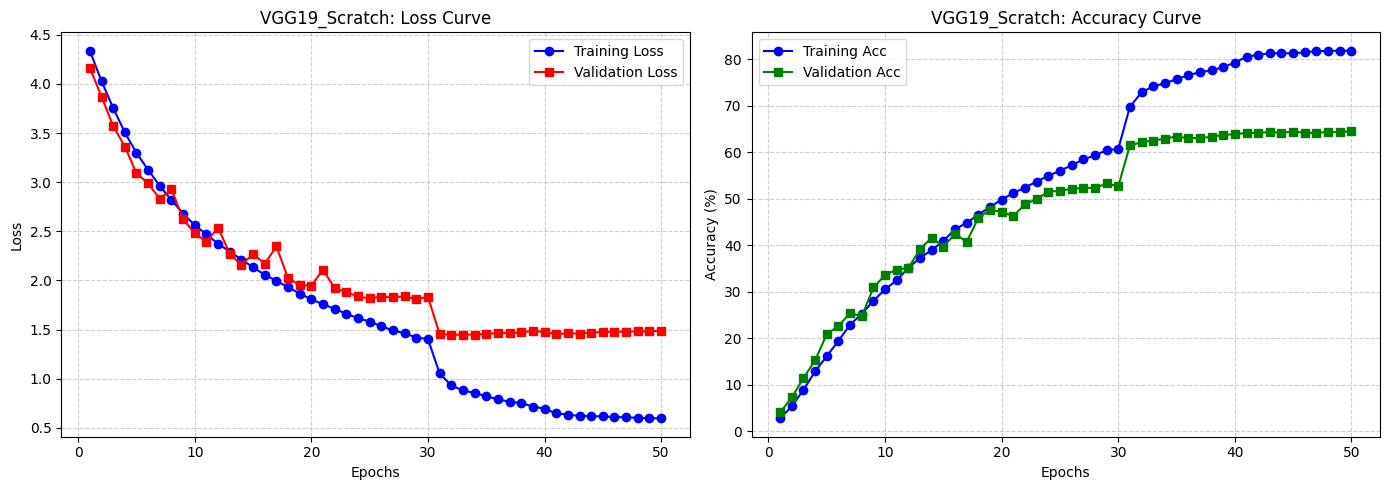

Original Test Result: 64.53%


64.53

In [18]:
run_single_model({
            "name": "VGG19_Scratch",
            "type": "scratch",
            "img_size": 32,
            "batch_size": 64,
            "epochs": 50,    
            "lr": 1e-2, 
            "scheduler": {
                "use": True,
                "milestones": [30, 40], 
                "gamma": 0.1
            }
})

#### 3. Chạy ResNet50_Scratch


==================== Running: ResNet50_Scratch (scratch) ====================
--> Đang tạo Transform chuẩn CIFAR-100 cho ResNet50_Scratch (Scratch/32x32)...
Initializing ResNet50_Scratch...
Epoch 1/50 [LR: 5.0e-02]


   Train Loss: 4.5769 | Acc: 3.15%
   Val Loss:   4.2823 | Acc: 5.20%
Epoch 2/50 [LR: 5.0e-02]


   Train Loss: 3.9608 | Acc: 7.77%
   Val Loss:   3.7834 | Acc: 11.03%
Epoch 3/50 [LR: 5.0e-02]


   Train Loss: 3.7049 | Acc: 11.72%
   Val Loss:   3.5670 | Acc: 14.42%
Epoch 4/50 [LR: 5.0e-02]


   Train Loss: 3.4486 | Acc: 16.53%
   Val Loss:   3.3352 | Acc: 18.61%
Epoch 5/50 [LR: 5.0e-02]


   Train Loss: 3.2057 | Acc: 20.93%
   Val Loss:   3.1538 | Acc: 21.95%
Epoch 6/50 [LR: 5.0e-02]


   Train Loss: 2.9673 | Acc: 25.32%
   Val Loss:   3.0559 | Acc: 25.25%
Epoch 7/50 [LR: 5.0e-02]


   Train Loss: 2.7441 | Acc: 29.59%
   Val Loss:   2.6887 | Acc: 31.33%
Epoch 8/50 [LR: 5.0e-02]


   Train Loss: 2.5062 | Acc: 34.33%
   Val Loss:   2.4259 | Acc: 36.07%
Epoch 9/50 [LR: 5.0e-02]


   Train Loss: 2.3049 | Acc: 38.72%
   Val Loss:   2.3969 | Acc: 37.75%
Epoch 10/50 [LR: 5.0e-02]


   Train Loss: 2.1377 | Acc: 42.43%
   Val Loss:   2.0816 | Acc: 44.38%
Epoch 11/50 [LR: 5.0e-02]


   Train Loss: 2.0205 | Acc: 44.84%
   Val Loss:   2.1090 | Acc: 43.61%
Epoch 12/50 [LR: 5.0e-02]


   Train Loss: 1.9140 | Acc: 47.35%
   Val Loss:   2.1351 | Acc: 44.50%
Epoch 13/50 [LR: 5.0e-02]


   Train Loss: 1.8316 | Acc: 49.22%
   Val Loss:   1.9800 | Acc: 47.27%
Epoch 14/50 [LR: 5.0e-02]


   Train Loss: 1.7550 | Acc: 51.00%
   Val Loss:   2.0976 | Acc: 46.14%
Epoch 15/50 [LR: 5.0e-02]


   Train Loss: 1.6933 | Acc: 52.62%
   Val Loss:   1.9810 | Acc: 46.44%
Epoch 16/50 [LR: 5.0e-02]


   Train Loss: 1.6405 | Acc: 53.95%
   Val Loss:   2.0224 | Acc: 46.87%
Epoch 17/50 [LR: 5.0e-02]


   Train Loss: 1.5975 | Acc: 54.76%
   Val Loss:   1.9213 | Acc: 48.91%
Epoch 18/50 [LR: 5.0e-02]


   Train Loss: 1.5591 | Acc: 55.86%
   Val Loss:   1.8805 | Acc: 49.55%
Epoch 19/50 [LR: 5.0e-02]


   Train Loss: 1.5215 | Acc: 56.55%
   Val Loss:   1.8089 | Acc: 50.79%
Epoch 20/50 [LR: 5.0e-02]


   Train Loss: 1.4807 | Acc: 57.89%
   Val Loss:   1.8582 | Acc: 50.48%
Epoch 21/50 [LR: 5.0e-02]


   Train Loss: 1.4621 | Acc: 58.29%
   Val Loss:   1.9184 | Acc: 49.85%
Epoch 22/50 [LR: 5.0e-02]


   Train Loss: 1.4227 | Acc: 59.06%
   Val Loss:   1.6868 | Acc: 54.37%
Epoch 23/50 [LR: 5.0e-02]


   Train Loss: 1.4085 | Acc: 59.67%
   Val Loss:   1.8253 | Acc: 51.21%
Epoch 24/50 [LR: 5.0e-02]


   Train Loss: 1.3898 | Acc: 60.05%
   Val Loss:   1.7858 | Acc: 52.43%
Epoch 25/50 [LR: 5.0e-02]


   Train Loss: 1.3645 | Acc: 60.68%
   Val Loss:   1.7743 | Acc: 51.87%
Epoch 26/50 [LR: 5.0e-03]


   Train Loss: 0.9177 | Acc: 73.30%
   Val Loss:   1.1239 | Acc: 67.76%
Epoch 27/50 [LR: 5.0e-03]


   Train Loss: 0.7672 | Acc: 77.18%
   Val Loss:   1.0977 | Acc: 68.69%
Epoch 28/50 [LR: 5.0e-03]


   Train Loss: 0.7025 | Acc: 79.04%
   Val Loss:   1.0910 | Acc: 69.28%
Epoch 29/50 [LR: 5.0e-03]


   Train Loss: 0.6509 | Acc: 80.67%
   Val Loss:   1.0887 | Acc: 68.92%
Epoch 30/50 [LR: 5.0e-03]


   Train Loss: 0.6090 | Acc: 81.63%
   Val Loss:   1.0878 | Acc: 69.23%
Epoch 31/50 [LR: 5.0e-03]


   Train Loss: 0.5716 | Acc: 82.58%
   Val Loss:   1.0768 | Acc: 69.78%
Epoch 32/50 [LR: 5.0e-03]


   Train Loss: 0.5356 | Acc: 83.64%
   Val Loss:   1.0972 | Acc: 69.37%
Epoch 33/50 [LR: 5.0e-03]


   Train Loss: 0.5016 | Acc: 84.88%
   Val Loss:   1.1159 | Acc: 69.65%
Epoch 34/50 [LR: 5.0e-03]


   Train Loss: 0.4750 | Acc: 85.39%
   Val Loss:   1.1204 | Acc: 69.69%
Epoch 35/50 [LR: 5.0e-03]


   Train Loss: 0.4466 | Acc: 86.16%
   Val Loss:   1.1443 | Acc: 69.43%
Epoch 36/50 [LR: 5.0e-03]


   Train Loss: 0.4207 | Acc: 87.10%
   Val Loss:   1.1706 | Acc: 69.04%
Epoch 37/50 [LR: 5.0e-03]


   Train Loss: 0.3954 | Acc: 87.61%
   Val Loss:   1.1830 | Acc: 68.84%
Epoch 38/50 [LR: 5.0e-03]


   Train Loss: 0.3800 | Acc: 88.28%
   Val Loss:   1.1781 | Acc: 69.31%
Epoch 39/50 [LR: 5.0e-03]


   Train Loss: 0.3653 | Acc: 88.68%
   Val Loss:   1.2095 | Acc: 68.64%
Epoch 40/50 [LR: 5.0e-03]


   Train Loss: 0.3382 | Acc: 89.64%
   Val Loss:   1.2117 | Acc: 68.71%
Epoch 41/50 [LR: 5.0e-04]


   Train Loss: 0.2362 | Acc: 93.44%
   Val Loss:   1.1118 | Acc: 70.88%
Epoch 42/50 [LR: 5.0e-04]


   Train Loss: 0.2051 | Acc: 94.43%
   Val Loss:   1.1079 | Acc: 71.09%
Epoch 43/50 [LR: 5.0e-04]


   Train Loss: 0.1898 | Acc: 95.10%
   Val Loss:   1.1143 | Acc: 71.16%
Epoch 44/50 [LR: 5.0e-04]


   Train Loss: 0.1783 | Acc: 95.42%
   Val Loss:   1.1162 | Acc: 71.27%
Epoch 45/50 [LR: 5.0e-04]


   Train Loss: 0.1710 | Acc: 95.73%
   Val Loss:   1.1268 | Acc: 71.32%
Epoch 46/50 [LR: 5.0e-04]


   Train Loss: 0.1633 | Acc: 95.88%
   Val Loss:   1.1258 | Acc: 71.53%
Epoch 47/50 [LR: 5.0e-04]


   Train Loss: 0.1556 | Acc: 96.22%
   Val Loss:   1.1326 | Acc: 71.45%
Epoch 48/50 [LR: 5.0e-04]


   Train Loss: 0.1503 | Acc: 96.34%
   Val Loss:   1.1384 | Acc: 71.18%
Epoch 49/50 [LR: 5.0e-04]


   Train Loss: 0.1461 | Acc: 96.48%
   Val Loss:   1.1336 | Acc: 71.41%
Epoch 50/50 [LR: 5.0e-04]


   Train Loss: 0.1415 | Acc: 96.59%
   Val Loss:   1.1425 | Acc: 71.30%
--> Biểu đồ training của riêng ResNet50_Scratch:


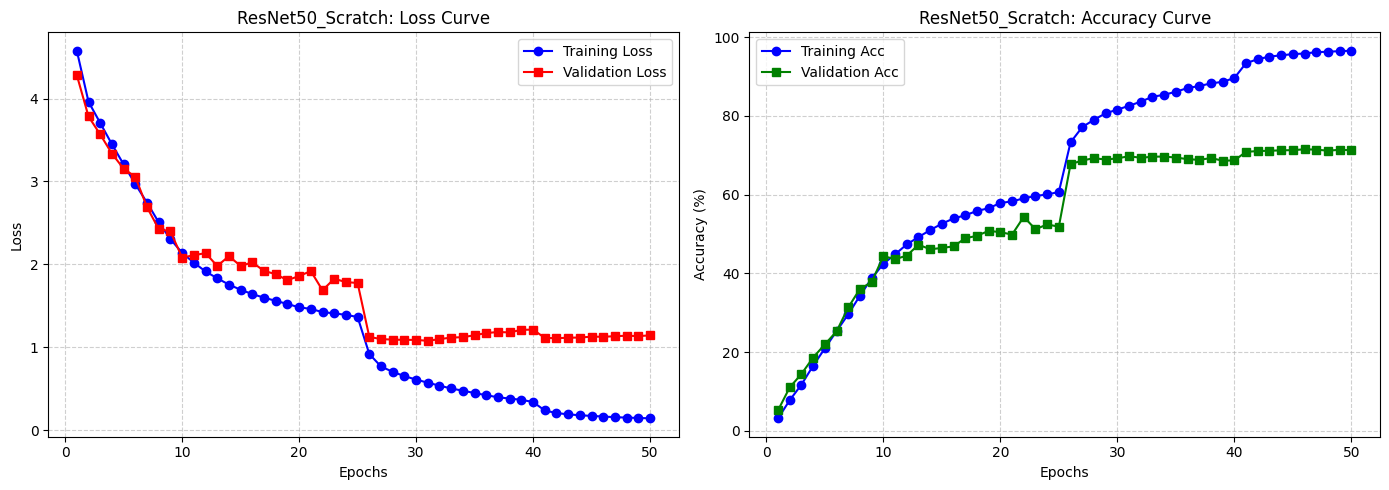

Original Test Result: 71.72%


71.72

In [19]:
run_single_model({
            "name": "ResNet50_Scratch",
            "type": "scratch",
            "img_size": 32,
            "batch_size": 64,
            "epochs": 50,
            "lr": 0.05, 
            "scheduler": {
                "use": True,
                "milestones": [25, 40], 
                "gamma": 0.1
            }
})

#### 4. Chạy VGG19_Finetune


==================== Running: VGG19_Finetune (finetune) ====================
--> Đang tạo Transform chuẩn ImageNet cho VGG19_Finetune...
Initializing VGG19_Finetune...
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [00:02<00:00, 244MB/s] 


Epoch 1/7 [LR: 1.0e-04]


   Train Loss: 2.0212 | Acc: 45.91%
   Val Loss:   1.2877 | Acc: 62.91%
Epoch 2/7 [LR: 1.0e-04]


   Train Loss: 1.2446 | Acc: 64.13%
   Val Loss:   1.0971 | Acc: 67.98%
Epoch 3/7 [LR: 1.0e-04]


   Train Loss: 1.0040 | Acc: 70.59%
   Val Loss:   1.0266 | Acc: 71.15%
Epoch 4/7 [LR: 1.0e-04]


   Train Loss: 0.8359 | Acc: 75.39%
   Val Loss:   0.9850 | Acc: 72.32%
Epoch 5/7 [LR: 1.0e-04]


   Train Loss: 0.7123 | Acc: 78.55%
   Val Loss:   1.0166 | Acc: 72.02%
Epoch 6/7 [LR: 1.0e-04]


   Train Loss: 0.6123 | Acc: 81.54%
   Val Loss:   0.9683 | Acc: 73.52%
Epoch 7/7 [LR: 1.0e-04]


   Train Loss: 0.5248 | Acc: 83.73%
   Val Loss:   0.9575 | Acc: 73.93%
--> Biểu đồ training của riêng VGG19_Finetune:


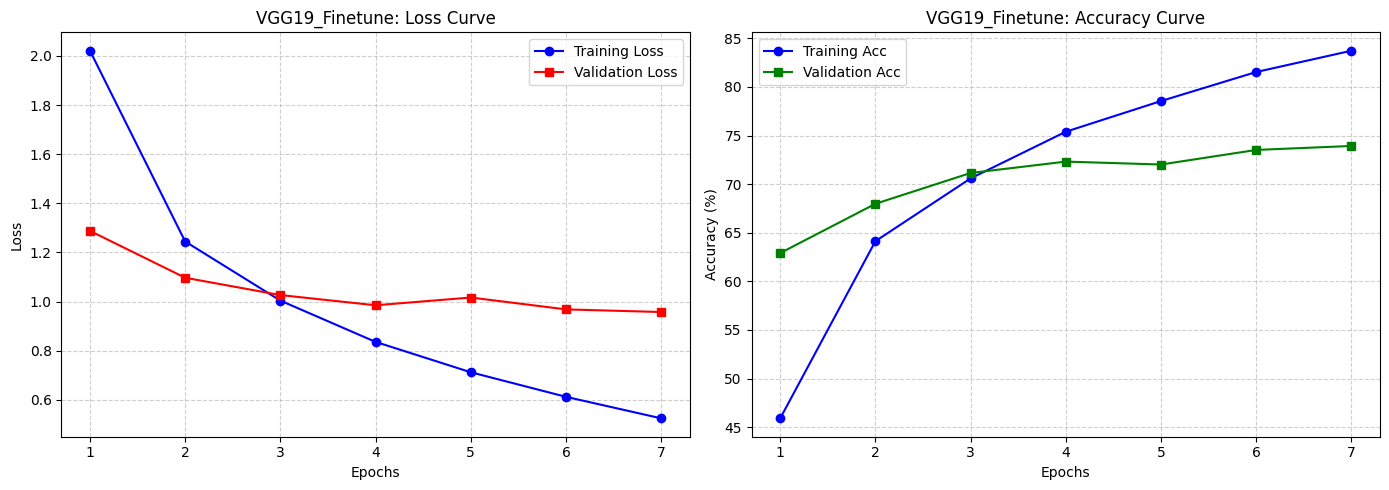

Original Test Result: 73.93%


73.93

In [20]:
run_single_model({
    "name": "VGG19_Finetune",
    "type": "finetune",
    "batch_size": 16,
    "img_size": 224,
    "epochs": 7,
    "lr": 1e-4,
    "scheduler": {"use": False} 
})

#### 5. Chạy ResNet50_Finetune


==================== Running: ResNet50_Finetune (finetune) ====================
--> Đang tạo Transform chuẩn ImageNet cho ResNet50_Finetune...
Initializing ResNet50_Finetune...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


Epoch 1/7 [LR: 1.0e-04]


   Train Loss: 1.6086 | Acc: 58.15%
   Val Loss:   0.8114 | Acc: 76.02%
Epoch 2/7 [LR: 1.0e-04]


   Train Loss: 0.7144 | Acc: 78.70%
   Val Loss:   0.6821 | Acc: 79.42%
Epoch 3/7 [LR: 1.0e-04]


   Train Loss: 0.5189 | Acc: 84.27%
   Val Loss:   0.6785 | Acc: 80.05%
Epoch 4/7 [LR: 1.0e-04]


   Train Loss: 0.3949 | Acc: 87.73%
   Val Loss:   0.6494 | Acc: 81.24%
Epoch 5/7 [LR: 1.0e-04]


   Train Loss: 0.3136 | Acc: 90.10%
   Val Loss:   0.6407 | Acc: 81.65%
Epoch 6/7 [LR: 1.0e-04]


   Train Loss: 0.2581 | Acc: 91.83%
   Val Loss:   0.6604 | Acc: 81.77%
Epoch 7/7 [LR: 1.0e-04]


   Train Loss: 0.2181 | Acc: 93.03%
   Val Loss:   0.6447 | Acc: 82.49%
--> Biểu đồ training của riêng ResNet50_Finetune:


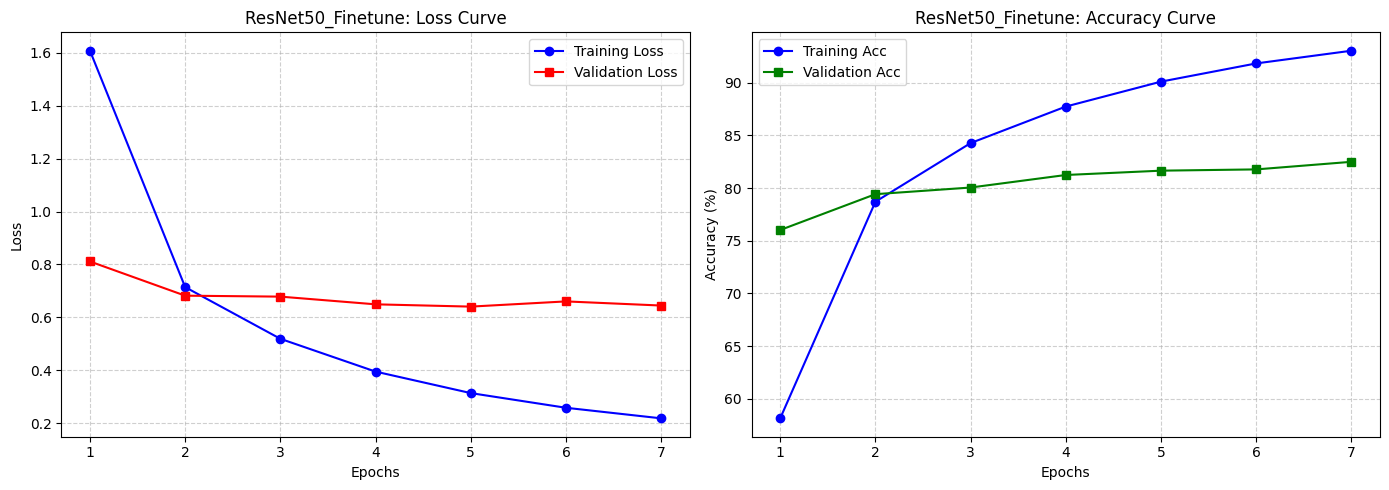

Original Test Result: 81.99%


81.99

In [21]:
run_single_model({
    "name": "ResNet50_Finetune",
    "type": "finetune",
    "batch_size": 32,
    "img_size": 224,
    "epochs": 7,
    "lr": 1e-4,
    "scheduler": {"use": False}
})

#### 6. Chạy CoCa_Finetune


==================== Running: CoCa_Finetune (finetune) ====================
--> Đang tạo Transform riêng chuẩn cho CoCa_Finetune (OpenCLIP)...


open_clip_pytorch_model.bin:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Initializing CoCa_Finetune...
Loading CoCa pretrained weights (Image Encoder only)...
Epoch 1/15 [LR: 5.0e-05]


   Train Loss: 2.8687 | Acc: 31.24%
   Val Loss:   1.7197 | Acc: 54.73%
Epoch 2/15 [LR: 5.0e-05]


   Train Loss: 1.2829 | Acc: 64.27%
   Val Loss:   1.1758 | Acc: 67.20%
Epoch 3/15 [LR: 5.0e-05]


   Train Loss: 0.9121 | Acc: 73.39%
   Val Loss:   1.1220 | Acc: 68.58%
Epoch 4/15 [LR: 5.0e-05]


   Train Loss: 0.7095 | Acc: 78.71%
   Val Loss:   0.9553 | Acc: 73.31%
Epoch 5/15 [LR: 5.0e-05]


   Train Loss: 0.5696 | Acc: 82.68%
   Val Loss:   0.9555 | Acc: 73.52%
Epoch 6/15 [LR: 5.0e-05]


   Train Loss: 0.4706 | Acc: 85.23%
   Val Loss:   0.9628 | Acc: 73.76%
Epoch 7/15 [LR: 5.0e-05]


   Train Loss: 0.3928 | Acc: 87.69%
   Val Loss:   0.9689 | Acc: 74.34%
Epoch 8/15 [LR: 5.0e-05]


   Train Loss: 0.3457 | Acc: 89.09%
   Val Loss:   1.0395 | Acc: 73.31%
Epoch 9/15 [LR: 5.0e-05]


   Train Loss: 0.2965 | Acc: 90.65%
   Val Loss:   1.0940 | Acc: 73.36%
Epoch 10/15 [LR: 5.0e-05]


   Train Loss: 0.2707 | Acc: 91.35%
   Val Loss:   1.0224 | Acc: 74.14%
Epoch 11/15 [LR: 5.0e-05]


   Train Loss: 0.2485 | Acc: 92.15%
   Val Loss:   1.0477 | Acc: 74.24%
Epoch 12/15 [LR: 5.0e-05]


   Train Loss: 0.2128 | Acc: 93.14%
   Val Loss:   1.1478 | Acc: 73.21%
Epoch 13/15 [LR: 5.0e-05]


   Train Loss: 0.2006 | Acc: 93.65%
   Val Loss:   1.1447 | Acc: 73.37%
Epoch 14/15 [LR: 5.0e-05]


   Train Loss: 0.1881 | Acc: 94.02%
   Val Loss:   1.1734 | Acc: 73.15%
Epoch 15/15 [LR: 5.0e-05]


   Train Loss: 0.1733 | Acc: 94.63%
   Val Loss:   1.1089 | Acc: 75.25%
--> Biểu đồ training của riêng CoCa_Finetune:


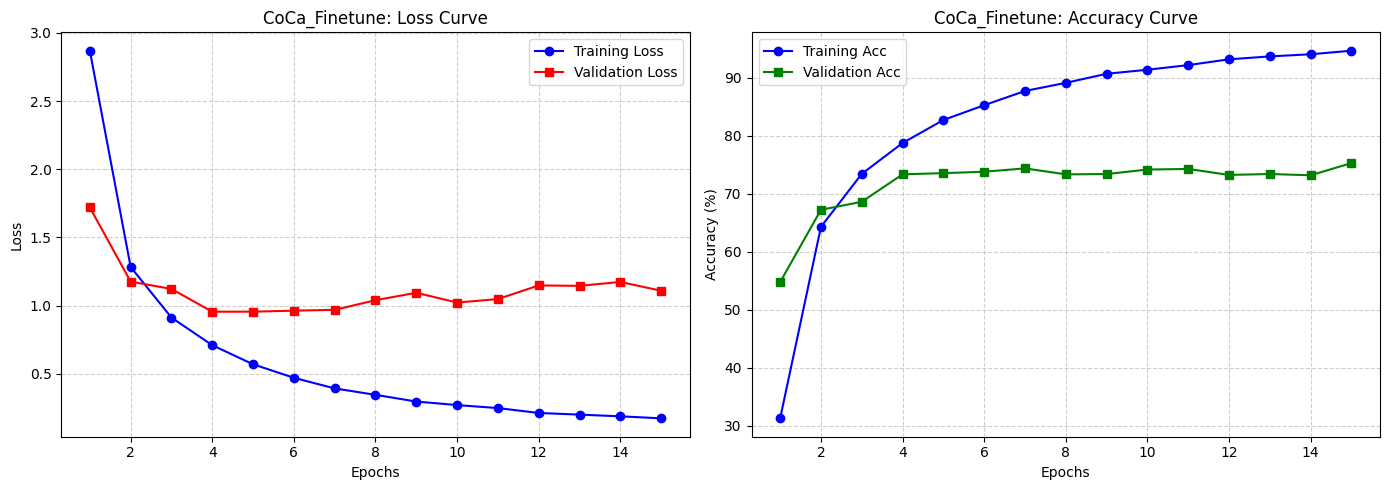

Original Test Result: 74.83%


74.83

In [22]:
run_single_model({
    "name": "CoCa_Finetune",    
    "type": "finetune",        
    "img_size": 224, 
    "batch_size": 32,
    "epochs": 15,               
    "lr": 5e-5,                
    "scheduler": {"use": False} 
})

# VIII. Trực quan hóa và so sánh kết quả

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_experiment_results(results_df, history_dict):
    # Cấu hình style
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except:
        plt.style.use('ggplot') 

    # --- PHẦN 1: BẢNG KẾT QUẢ ---
    print("\n" + "="*40)
    print("  BẢNG TỔNG HỢP KẾT QUẢ (SORTED)")
    print("="*40)
    # Sắp xếp theo Accuracy giảm dần 
    results_sorted = results_df.sort_values(by='Test Accuracy', ascending=False)
    display(results_sorted)

    # --- PHẦN 2: BAR CHART (SO SÁNH TEST ACCURACY) ---
    plt.figure(figsize=(12, 6))
    
    colors = []
    for t in results_sorted['Type']:
        if t == 'scratch': colors.append('#e74c3c')   # Đỏ
        elif t == 'finetune': colors.append('#2ecc71') # Xanh lá
        else: colors.append('#3498db')                # Xanh dương

    bars = plt.bar(results_sorted['Model'], results_sorted['Test Accuracy'], color=colors, alpha=0.85)
    
    plt.xlabel('Model', fontsize=12, fontweight='bold')
    plt.ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    plt.title('Comparison of Test Accuracy (Higher is Better)', fontsize=15, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Hiển thị số liệu trên đầu cột
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.2f}%',
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Thêm chú thích loại model
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#e74c3c', label='Scratch'),
                       Patch(facecolor='#2ecc71', label='Finetune'),
                       Patch(facecolor='#3498db', label='Zero-shot')]
    plt.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()

    # --- PHẦN 3: LINE CHART (LEARNING CURVES) ---
    plt.figure(figsize=(12, 7))
    
    has_history = False
    markers = ['o', 's', '^', 'D', 'v', 'p'] # Marker khác nhau cho mỗi đường
    
    for i, (model_name, history) in enumerate(history_dict.items()):
        if not history or not history.get('val'): # Bỏ qua model không có history (như Zero-shot)
            continue
            
        has_history = True
        val_acc = history['val']
        epochs = range(1, len(val_acc) + 1)
        
        plt.plot(epochs, val_acc, label=model_name, linewidth=2, marker=markers[i % len(markers)], markersize=5)

    if has_history:
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Validation Accuracy (%)', fontsize=12)
        plt.title('Training Progress (Validation Accuracy)', fontsize=15, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # --- PHẦN 4: SCATTER PLOT (PARAMS vs ACCURACY) ---
    # So sánh hiệu quả: Model nhỏ mà chính xác cao là tốt nhất
    
    # Xử lý cột Params (chuyển chuỗi '23.5M' -> số float 23.5)
    def parse_params(x):
        if isinstance(x, str) and 'M' in x:
            return float(x.replace('M', ''))
        return 0.0

    sizes = results_df['Params'].apply(parse_params)
    accs = results_df['Test Accuracy']
    names = results_df['Model']
    types = results_df['Type']

    if sizes.sum() > 0: # Chỉ vẽ nếu có thông tin params
        plt.figure(figsize=(10, 8))
        
        # Map màu theo Type
        color_map = {'scratch': '#e74c3c', 'finetune': '#2ecc71', 'zeroshot': '#3498db'}
        colors = [color_map.get(t, 'gray') for t in types]
        
        plt.scatter(sizes, accs, s=150, c=colors, alpha=0.7, edgecolors='black')

        # Gán nhãn tên model cho từng điểm
        for i, txt in enumerate(names):
            plt.annotate(txt, (sizes[i], accs[i]), xytext=(5, 5), textcoords='offset points', fontsize=9)

        plt.xlabel('Number of Parameters (Millions)', fontsize=12)
        plt.ylabel('Test Accuracy (%)', fontsize=12)
        plt.title('Efficiency Trade-off: Model Size vs. Accuracy', fontsize=15, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.5)
        
        # Legend
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        plt.show()



  BẢNG TỔNG HỢP KẾT QUẢ (SORTED)


,Model,Type,Test Accuracy,Params
4,ResNet50_Finetune,finetune,81.99,23.71M
5,CoCa_Finetune,finetune,74.83,89.22M
3,VGG19_Finetune,finetune,73.93,139.99M
2,ResNet50_Scratch,scratch,71.72,23.71M
1,VGG19_Scratch,scratch,64.53,39.32M
0,SimpleCNN,scratch,52.94,1.19M


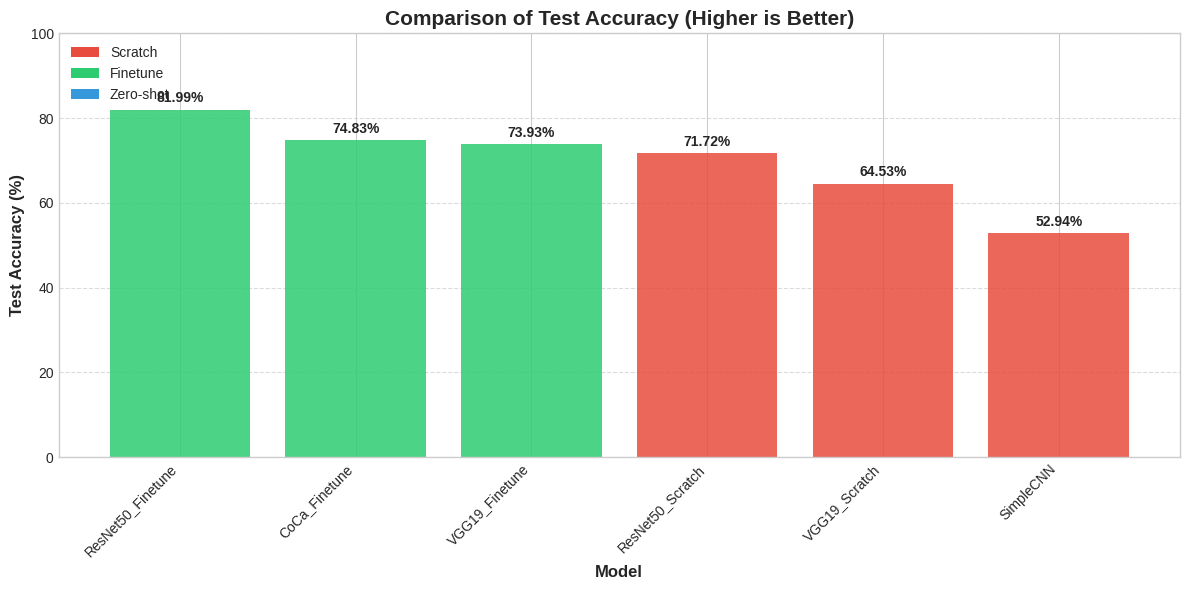

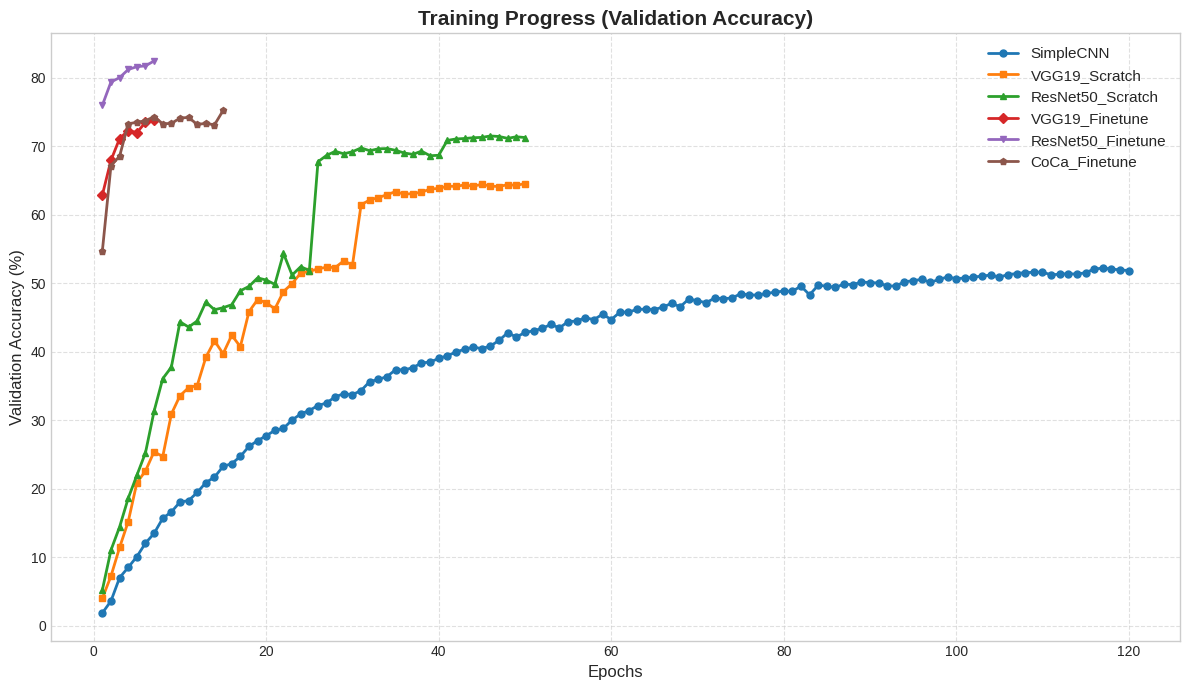

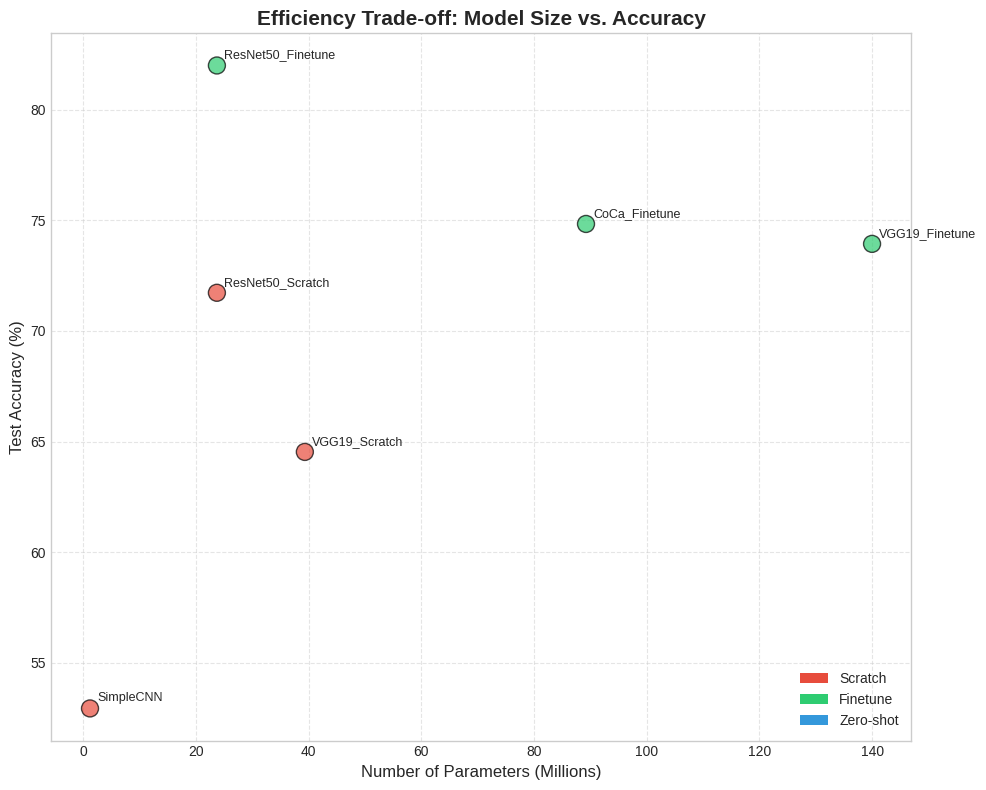

In [29]:
import pandas as pd
df_final_results = pd.DataFrame(global_results_list)

visualize_experiment_results(df_final_results, global_history_dict)